# Imports

In [1]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb

!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb
!pip install ultralytics
!pip install paddlepaddle==2.5.*
! pip install paddleocr
!pip install imutils

--2025-02-04 16:07:52--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 91.189.91.82, 185.125.190.82, 185.125.190.81, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|91.189.91.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1323104 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  5.60MB/s    in 0.2s    

2025-02-04 16:07:52 (5.60 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb’ saved [1323104/1323104]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 120769 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.23) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.23) ...
debconf: unable to initialize front

In [ ]:
import cv2
import torch
import torchvision as tv
import numpy as np
import pandas as pd
# import polars as pl
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import ast
import os
import ultralytics
from ultralytics import YOLO
import PIL
import tqdm
import shutil
import paddleocr
from PIL import Image
from matplotlib.image import imread
import imutils
import math

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Вспом. функции

Данные функции являются вспомогательными для подготовки датасетов и со стороны оптимизации требуют доработки, если понадобится их использовать больше одного раза.

Парс названий файлов 1 датасета для извлечения реального значения, тк в .csv присутствуют опечатки и неточности. Пример: файлы с окончанием на _0 не имеют на изображении части после запятой, как и самой запятой.

In [ ]:
def parce_photo_name(x):
    counter = 0
    dec = ''
    fl = ''
    for sym in x:
        if sym == '_' or sym == '.':
            counter += 1
            continue
        if counter == 3:
            dec += sym
        if counter == 4:
            fl += sym
    true_dec = '00000'
    true_fl = '000'
    if len(fl) == 1:
        return true_dec[:len(true_dec) - len(dec)] + dec
    return true_dec[:len(true_dec) - len(dec)] + dec + '.' + fl + true_fl[len(fl):]

Парс словаря с координатами

In [ ]:
def parce_dict(x):
    return ast.literal_eval(x)
def ro(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
def find_top_unique(d):
    first = d[-1]
    i = 1
    while True:
        if (d[-1 - i][1] not in first[-2:]) and (d[-1 - i][2] not in first[-2:]):
            return [first, d[- 1 - i]]
        i += 1

Функция для копирования фотографий из одной папки в другую. Нужна была при кропе изображений.

In [ ]:
def copy_image_simple(source_path, destination_path):
    """Копирует изображение (простой вариант).

    Args:
        source_path: Путь к исходному изображению.
        destination_path: Путь к целевой папке.
    """
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

    try:
        shutil.copy(source_path, destination_path)
        pass
        # print(f"Изображение скопировано из '{source_path}' в '{destination_path}'")
    except FileNotFoundError:
        pass
        # print(f"Ошибка: Файл '{source_path}' не найден.")
    except Exception as e:
        pass
        # print(f"Ошибка при копировании: {e}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# def get_image_data(name = None):
#     if name == None:
#         name = data.sample(1).photo_name.item()
#     image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
#     # mask = bgr2rgb(cv2.imread(dir + 'masks/' + name))
#     # collage = bgr2rgb(cv2.imread(dir + 'collage/' + name))
#     return  image

# Модели

## 1. Модель, которая предсказывает угол поворота
 (можно доработать, чтобы была составляющая детекции, распознавания и распознавания угла, я заинферила только часть с углом, потому что мне интересна была именно она)

In [ ]:
dir_angle_model = '/content/drive/MyDrive/cv_project/cv_project'

In [ ]:
ocr_angle = paddleocr.PaddleOCR(det_pse_box_thresh=0.1,
                                det_east_score_thresh=0.1,
                                det_db_box_thresh=0.1,
                                det_db_thresh=0.1,
                                use_angle_cls=True,
                                cls_model_dir=os.path.join(dir_angle_model, "ch_ppocr_mobile_v2.0_cls_infer/inference"),
                                cls_yaml_path = os.path.join(dir_angle_model, "ch_ppocr_mobile_v2.0_cls_infer/cls_mv3.yml"),
                                cls_thresh=0.1,
                                label_list=['0', '180']) # при особой необходимости можно зафайнтюнить под большее количество углов
                                                         # 0 и 180 это значения по умолчанию дефолтной модели

download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar to /root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer/ch_PP-OCRv4_det_infer.tar


100%|██████████| 4780/4780 [00:17<00:00, 280.09it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer/ch_PP-OCRv4_rec_infer.tar


100%|██████████| 10720/10720 [00:18<00:00, 576.13it/s] 


[2025/01/29 11:58:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.1, det_db_box_thresh=0.1, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.1, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.1, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

In [ ]:
# ! paddleocr --help

In [ ]:
if False:
    im = '/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_1000_value_176_881.jpg'
    image = imread(im)
    result = ocr_angle.ocr(im, det=False, rec=False, cls=True)
    if result[0][0][0] == '180':
        print(f'Изображение перевернуто с вероятностью {result[0][0][1]}')
    else:
        print(f'Изображение не перевернуто с вероятностью {result[0][0][1]}')
    plt.imshow(image)
    plt.show()

## 2. YOLOv8-obb для детекции bbox(oriented bbox type)

Данная модель будет обучаться на 1-м датасете, поскольку из такого формата данных разметки легче всего извлечь bounding box.

Сами же данные сильно аугментированные, а иногда не читаемы человеком

### 2.1. Подготовка датасета

Формат данных для обучения модели yolov8-obb:
- data.yaml файл с конфигурацией модели(расположение train, test, классы)
- папка с train
- папка с test

В папках находятся 2 папки с изображениями (images) и с аналогичными названиям изображений .txt файлы с форматом данных "class x1 y1 x2 y2 x3 y3 x4 y4", где координаты отнормированы по размерам изображений

In [ ]:
dir = './datasets/dataset_1/'

In [ ]:
data_updated = pd.read_csv(f'/content/drive/MyDrive/cv_project/cv_project/dataset_1.csv')

In [ ]:
data_updated.head(2)

photo_name    value  \
0  id_53_value_595_825.jpg  595.825   
1  id_553_value_65_475.jpg   65.475   

                                            location  imsize  width  height  \
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y...    1000   1000    1333   
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y...       1   1333    1000   

   target_pct  
0     0.00736  
1     0.01745

In [ ]:
data_updated.__len__()

1244

In [ ]:
if False: #False - данные уже подготовлены
    iterator = 0
    for index, row in data_updated.iterrows():
        iterator += 1
        file_name = row['photo_name']
        points = parce_dict(row['location'])['data']

        points_data = []

        for i in range(len(points)): # прошу игнорировать простоту данного алгоритма
            j = 0
            while j < i:
                points_data.append([ro(*list(points[i].values()), *list(points[j].values())), i, j])
                j += 1

        points_data.sort(key = lambda x:x[0]) # сортируем значения по первой координате - то есть расстоянию между точками

        top2pairs = find_top_unique(points_data[:])
        sorted_points = np.array(sorted(np.array(top2pairs)[:, -2:].flatten()), dtype=int)

        labels = np.array([[points[point]['x'], points[point]['y']] for point in sorted_points])

        labels = np.array(labels).flatten()

        class_label = "0"
        for x in labels:
            class_label += f" {x}"

        if iterator <= 300:
            file_path = os.path.join('./datasets/dataset.yolov8-obb/test/labels/', f"{file_name[:-4]}.txt")
            with open(file_path, "w") as f:
                f.write(class_label)
            source_image_path = f"/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/{file_name}"
            destination_folder_path = "/content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/test/images/"
            copy_image_simple(source_image_path, destination_folder_path)
        if iterator > 300 and iterator <= 600:
            file_path = os.path.join('./datasets/dataset.yolov8-obb/val/labels/', f"{file_name[:-4]}.txt")
            with open(file_path, "w") as f:
                f.write(class_label)
            source_image_path = f"/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/{file_name}"
            destination_folder_path = "/content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/val/images/"
            copy_image_simple(source_image_path, destination_folder_path)
        if iterator > 600:
            file_path = os.path.join('./datasets/dataset.yolov8-obb/train/labels/', f"{file_name[:-4]}.txt")
            with open(file_path, "w") as f:
                f.write(class_label)
            source_image_path = f"/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/{file_name}"
            destination_folder_path = "/content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/train/images/"
            copy_image_simple(source_image_path, destination_folder_path)

### 2.2. Обучение модели

In [ ]:
# model = YOLO('yolov8n-obb.pt')

In [ ]:
yolo_model = YOLO('/content/drive/MyDrive/cv_project/cv_project/runs/obb/retrain_42/weights/best.pt')

In [ ]:
res_yolo = yolo_model.train(model='/content/drive/MyDrive/cv_project/cv_project/runs/obb/retrain_42/weights/best.pt',
    data='/content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/data (1).yaml',
    epochs=50,
    patience=5,
    batch=16,
    imgsz=640,
    save=True,
    save_period=5,
    device='mps',
    name='retrain_42',
    pretrained='/content/drive/MyDrive/cv_project/cv_project/runs/obb/retrain_42/weights/best.pt',
    # resume=True,
    multi_scale=True,
    plots=True)

Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=obb, mode=train, model=/content/drive/MyDrive/cv_project/cv_project/runs/obb/retrain_42/weights/best.pt, data=/content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/data (1).yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=mps, workers=8, project=None, name=retrain_42, exist_ok=False, pretrained=/content/drive/MyDrive/cv_project/cv_project/runs/obb/retrain_42/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/train/labels.cache... 644 images, 0 backgrounds, 0 corrupt: 100%|██████████| 644/644 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/cv_project/cv_project/datasets/dataset.yolov8-obb/val/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]


Plotting labels to runs/obb/retrain_42/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/obb/retrain_42
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      0.833     0.5577       1.69          9        416: 100%|██████████| 41/41 [03:21<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [02:53<00:00,  9.11s/it]

                   all        300        300      0.969      0.973      0.987      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      0.813     0.5576      1.648         11        928: 100%|██████████| 41/41 [03:46<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.06s/it]

                   all        300        300      0.975      0.977      0.991      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.7988     0.5469      1.582         15        672: 100%|██████████| 41/41 [03:38<00:00,  5.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.05s/it]

                   all        300        300      0.964      0.985      0.988      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      0.862     0.6142      1.727         13        512: 100%|██████████| 41/41 [03:45<00:00,  5.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.09s/it]

                   all        300        300      0.966      0.961      0.986      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8315       0.59      1.745          6        320: 100%|██████████| 41/41 [03:42<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.13s/it]

                   all        300        300      0.954      0.979      0.983      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8507     0.5781       1.66          5        864: 100%|██████████| 41/41 [03:54<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.06s/it]

                   all        300        300      0.969      0.967      0.985      0.811
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.449 hours.
Optimizer stripped from runs/obb/retrain_42/weights/last.pt, 6.6MB
Optimizer stripped from runs/obb/retrain_42/weights/best.pt, 6.6MB

Validating runs/obb/retrain_42/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
YOLOv8n-obb summary (fused): 187 layers, 3,077,414 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


                   all        300        300      0.972      0.973      0.988      0.813
Speed: 0.4ms preprocess, 39.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/obb/retrain_42


Note: можно(нужно) дообучить. Можно с аугментациями, чтобы разнообразить выборку и увеличить объем. Причина остановки: Training stopped early as no improvement observed in last 5 epochs. Причина желания продолжить: см. results.png

### 2.3. Применение модели

Уверенность 0.75 показалась наилучшей на валидационной выборке. Однако, требуется дообучение модели для повышения уверенности.

In [ ]:
full_dir2 = '/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg'
pred_2 = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir2),
                            max_det=1, project='yolo_detection')


image 1/1 /content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg: 480x640 82.5ms
Speed: 3.2ms preprocess, 82.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to yolo_detection/predict3
1 label saved to yolo_detection/predict3/labels


In [ ]:
pred_2[0].obb

ultralytics.engine.results.OBB object with attributes:

cls: tensor([0.])
conf: tensor([0.9044])
data: tensor([[6.4455e+02, 6.6650e+02, 5.3257e+02, 1.2461e+02, 2.5907e-02, 9.0441e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (1000, 1333)
shape: torch.Size([1, 7])
xywhr: tensor([[6.4455e+02, 6.6650e+02, 5.3257e+02, 1.2461e+02, 2.5907e-02]])
xyxy: tensor([[376.7414, 597.3154, 912.3589, 735.6829]])
xyxyxyxy: tensor([[[909.1309, 735.6829],
         [912.3589, 611.1111],
         [379.9693, 597.3154],
         [376.7414, 721.8872]]])
xyxyxyxyn: tensor([[[0.6820, 0.7357],
         [0.6844, 0.6111],
         [0.2850, 0.5973],
         [0.2826, 0.7219]]])

In [ ]:
full_dir = '/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg'
pred_1 = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir),
                            max_det=1, project='yolo_detection')


image 1/1 /content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg: 480x640 42.0ms
Speed: 2.9ms preprocess, 42.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to yolo_detection/predict4
1 label saved to yolo_detection/predict4/labels


In [ ]:
# TODO: добавить везде project =

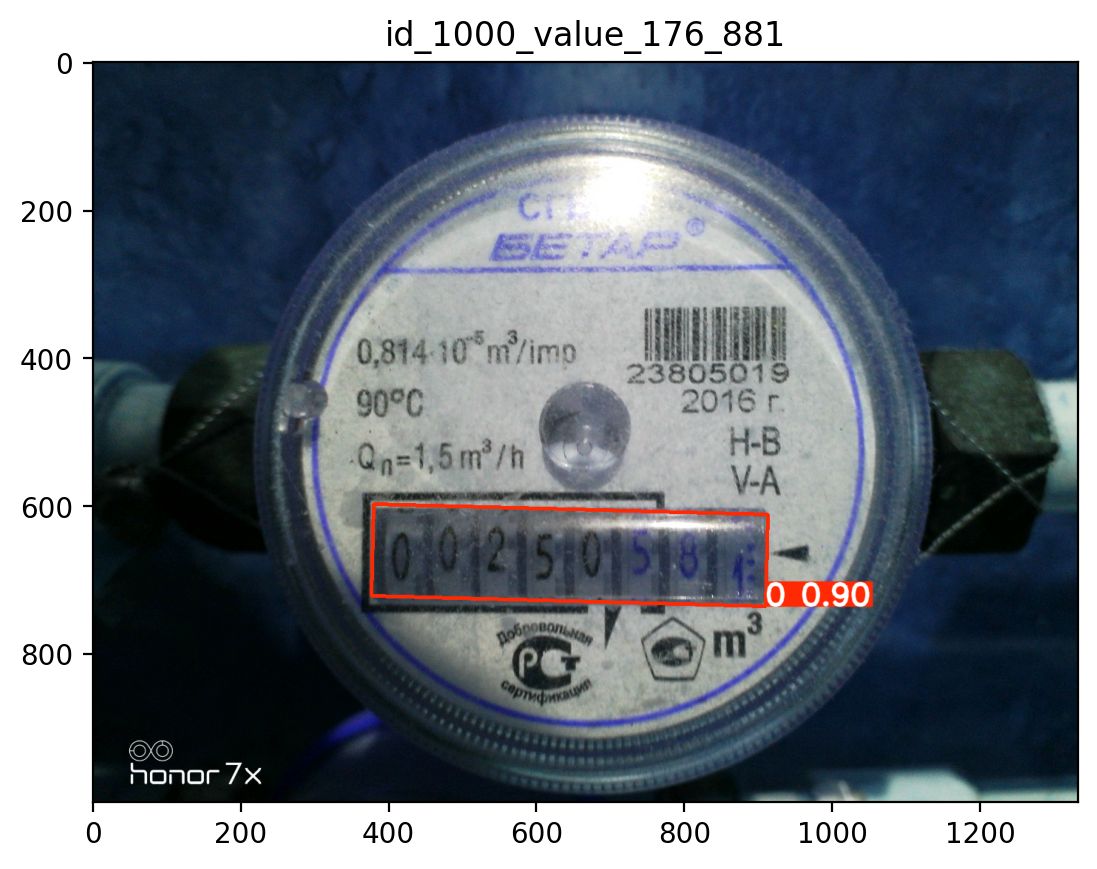

In [ ]:
plt.imshow(pred_1[0].plot())
plt.title('id_1000_value_176_881')
plt.show()

In [ ]:
full_dir_3 = '/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg'
pred_3 = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=os.path.join(full_dir_3),
                            max_det=1, project='yolo_detection')


image 1/1 /content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg: 480x640 42.0ms
Speed: 3.1ms preprocess, 42.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to yolo_detection/predict5
1 label saved to yolo_detection/predict5/labels


In [ ]:
print(f'Угол вращения: {pred_1[0].obb.xywhr[0][-1].rad2deg():.3}')

Угол вращения: 1.48


Можно предиктить сразу содержимое директории, но тогда нужно правильно отследить результаты, где получилось несколько предсказаний/ни одного
(Это реализовано)

In [ ]:
full_dir = '/content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg'
preds = yolo_model.predict(save=True, save_txt=True, conf=0.75, source=full_dir)


image 1/1 /content/drive/MyDrive/cv_project/cv_project/datasets/dataset_1/images/id_274_value_250_581.jpg: 480x640 40.1ms
Speed: 3.0ms preprocess, 40.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to yolo_detection/predict5
1 label saved to yolo_detection/predict5/labels


## 3. Пример разворота изображения

## 3.1. Угол

In [ ]:
rotated_image = imutils.rotate(pred_1[0].plot(), angle=int(pred_1[0].obb.xywhr[0][-1].rad2deg()))
rotated_image_ = imutils.rotate(pred_1[0].orig_img, angle=int(pred_1[0].obb.xywhr[0][-1].rad2deg()))

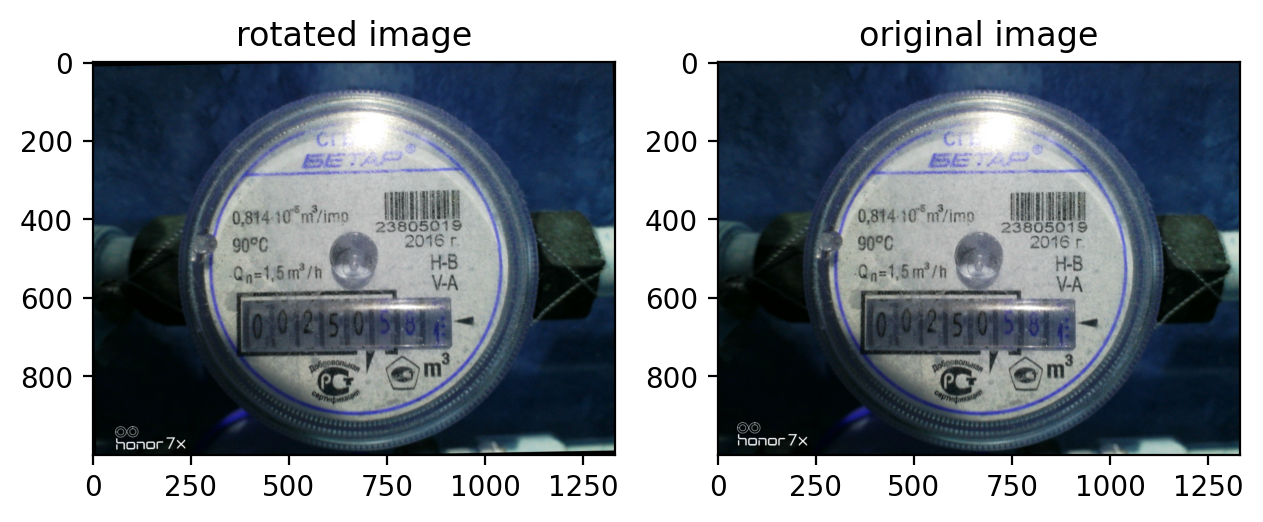

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rotated_image_)
ax[0].set_title('rotated image')
ax[1].imshow(pred_1[0].orig_img)
ax[1].set_title('original image')
plt.tight_layout()
plt.show()

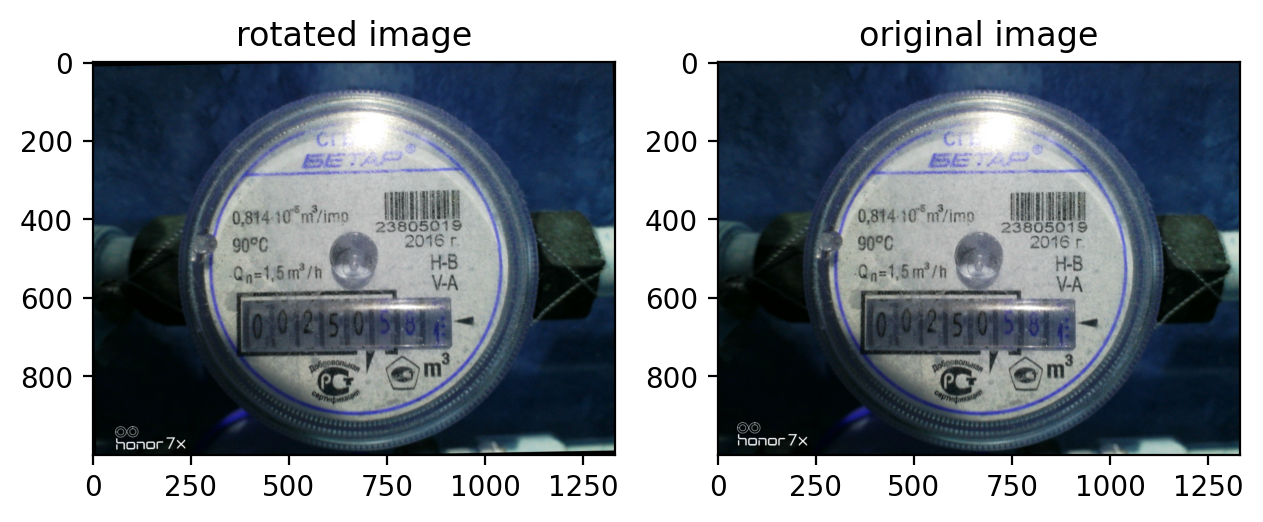

In [ ]:
rotated_image_2 = imutils.rotate(pred_2[0].orig_img, angle=int(pred_2[0].obb.xywhr[0][-1].rad2deg()))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rotated_image_2)
ax[0].set_title('rotated image')
ax[1].imshow(pred_2[0].orig_img)
ax[1].set_title('original image')
plt.tight_layout()
plt.show()

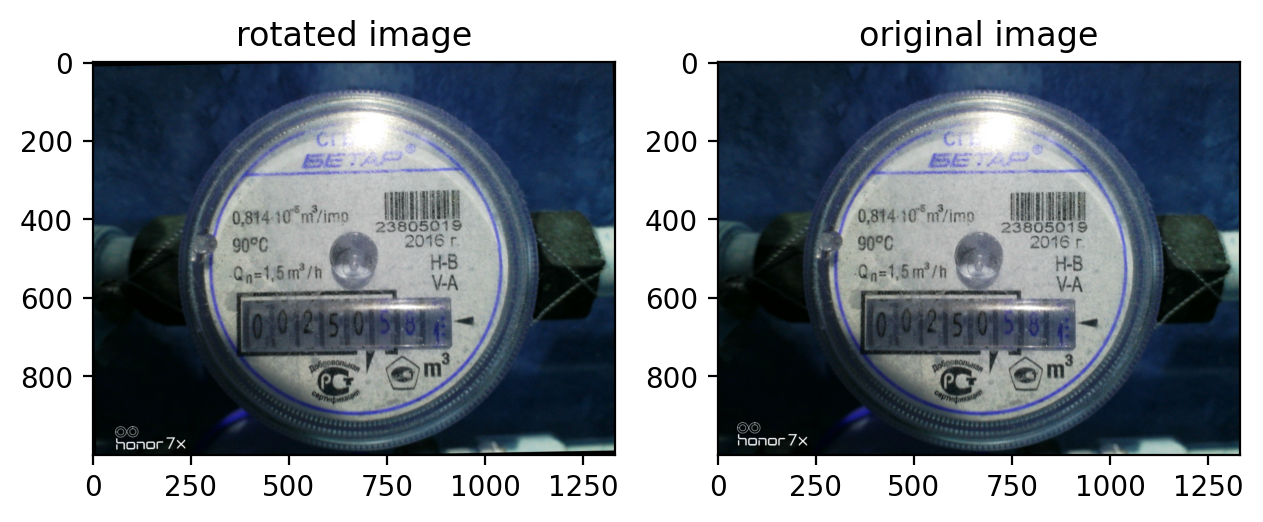

In [ ]:
rotated_image_3 = imutils.rotate(pred_3[0].orig_img, angle=int(pred_3[0].obb.xywhr[0][-1].rad2deg()))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rotated_image_3)
ax[0].set_title('rotated image')
ax[1].imshow(pred_3[0].orig_img)
ax[1].set_title('original image')
plt.tight_layout()
plt.show()

In [ ]:
ocr_angle.ocr(rotated_image_3[:, :], det=False, rec=False)

[[['0', 0.719745]]]

Проблема!!!!!!! Он считает, что изображение перевернуто. Догадка: в углу есть дата читаемым шрифтом, скорее всего моделька распознает именно эту строчку как наиболее вероятную дляидентификации поворота, требуется сделать кроп.

In [ ]:
ocr_angle.ocr(rotated_image_3[200:850, :], det=False, rec=False)

[[['0', 0.8337001]]]

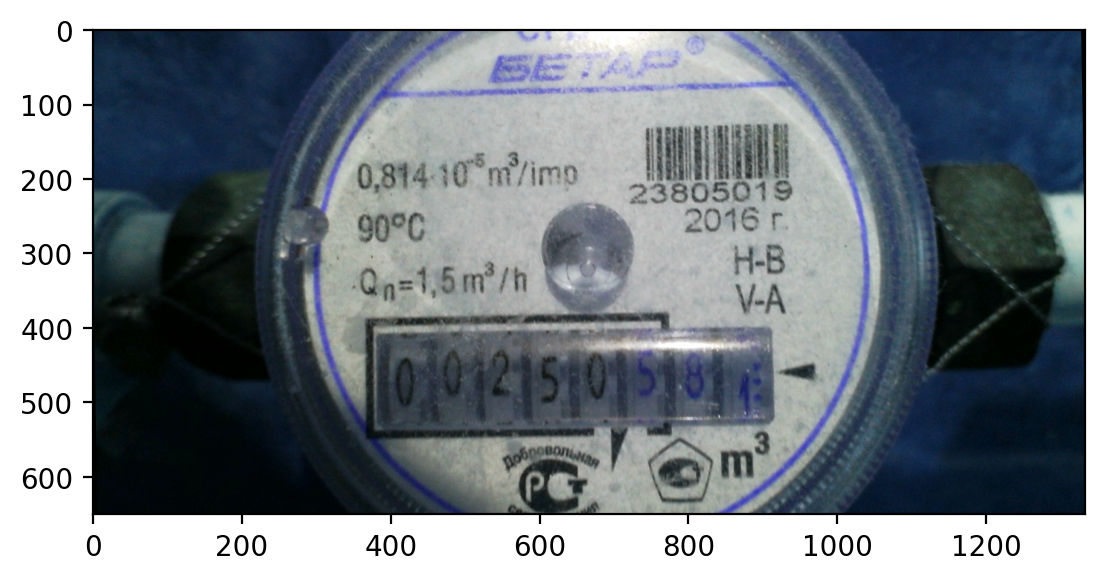

In [ ]:
plt.imshow(rotated_image_3[200:850, :])
plt.show()

Похоже, догадка оказалась верной и при обрезке у нас получается правильное значене при определении ориентации текста.

In [ ]:
rotated_image_2_2 = imutils.rotate(rotated_image_2, angle=180)

In [ ]:
result = ocr_angle.ocr(rotated_image_2, det=False, rec=False)
result2 = ocr_angle.ocr(rotated_image_2_2, det=False, rec=False)
print(result, result2)

[[['0', 0.719745]]] [[['180', 0.7109062]]]


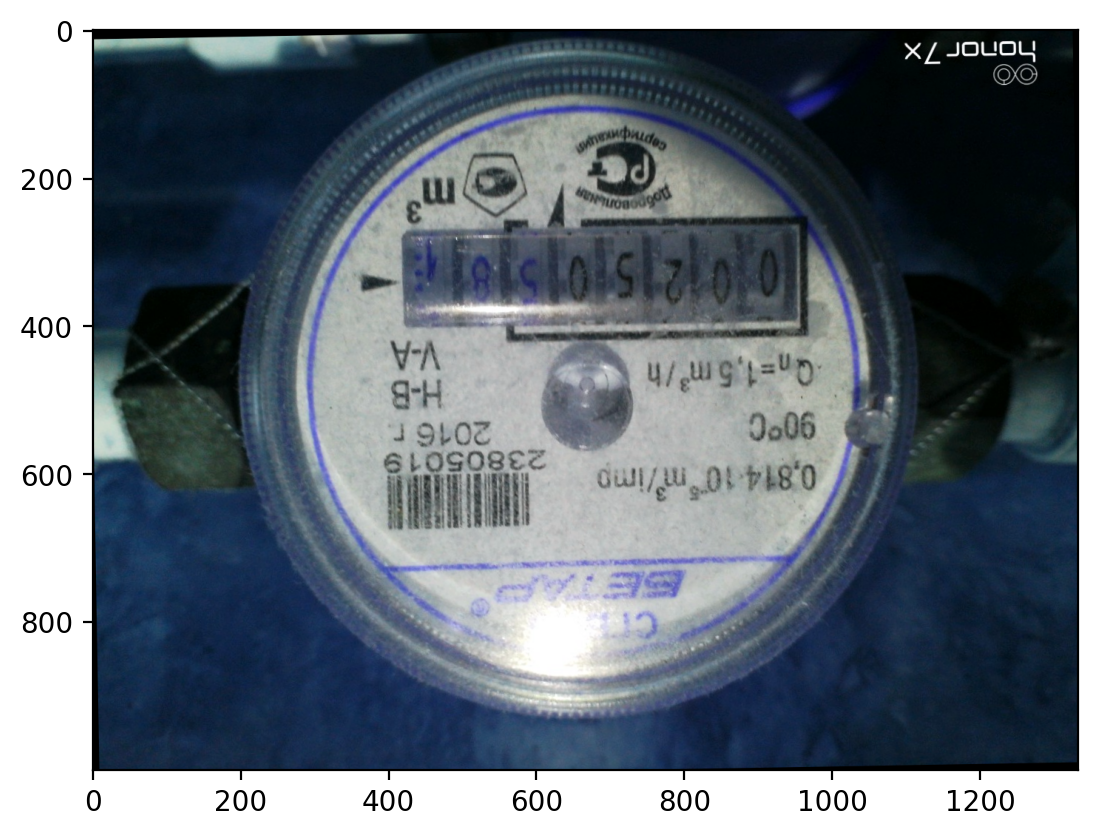

In [ ]:
plt.imshow(rotated_image_2_2)
plt.show()

## 3.2. Bbox crop

In [ ]:
# вычисляет 4 угла повернутого bounding box
def get_rotated_bbox_corners(center_x, center_y, width, height, rotate):
    cos_angle = np.cos(rotate)
    sin_angle = np.sin(rotate)

    half_width = width / 2
    half_height = height / 2

    # исходные координаты углов относительно центра (0, 0)
    corners = np.array([
        [-half_width, -half_height],
        [half_width, -half_height],
        [half_width, half_height],
        [-half_width, half_height]
    ], dtype=float)

    rotation_matrix = np.array([
        [cos_angle, -sin_angle],
        [sin_angle, cos_angle]
    ])

    rotated_corners = np.dot(corners, rotation_matrix.T) + np.array([center_x, center_y])

    return rotated_corners


def get_crop_coords(rotated_corners):

  min_x = int(np.min(rotated_corners[:, 0]))
  min_y = int(np.min(rotated_corners[:, 1]))
  max_x = int(np.max(rotated_corners[:, 0]))
  max_y = int(np.max(rotated_corners[:, 1]))

  return min_x, min_y, max_x, max_y

def rotate_image(image, rotation):

  height, width = image.shape[:2]
  center = (width / 2, height / 2)

  rotation_matrix = cv2.getRotationMatrix2D(center, np.rad2deg(rotation), 1.0)
  rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

  return rotated_image

def rotate_image_obb(obb_object):

   rotated_image = imutils.rotate(obb_object.plot(),
                                  angle=int(obb_object.obb.xywhr[0][-1].rad2deg()))

   return rotated_image

def crop_rotate(image, center_x, center_y, width, height, rotation, dwidth = 0):

    rotated_image = rotate_image(image, rotation)
    rotated_corners = get_rotated_bbox_corners(center_x, center_y, width + dwidth, height, rotation) #try:?
    min_x, min_y, max_x, max_y = get_crop_coords(rotated_corners)

    cropped_image = rotated_image[min_y:max_y, min_x:max_x]

    return cropped_image

In [ ]:
def crop_rotate_obb(obb_object):
    center_x, center_y, width, height, rotate = obb_object.obb.xywhr[0].cpu().numpy()
    new_img = crop_rotate(obb_object.orig_img, center_x, center_y, width, height, rotate, width*0.2)
    return new_img

In [ ]:
cropped_1 = crop_rotate_obb(pred_1[0])

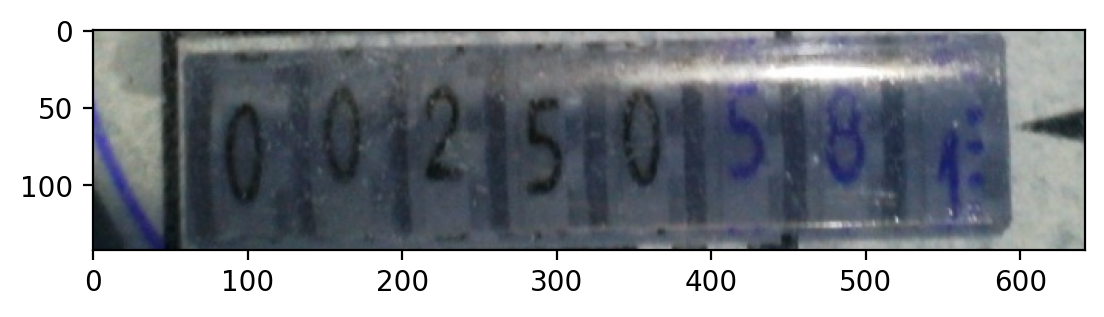

In [ ]:
plt.imshow(cropped_1)
plt.show()

Цель - свести получаемые данные из yolo к такому виду для лучшей читаемости PaddleOCR

Проблема: считаны не все цифры, брать границы побольше? (Добавлено)\
Также нужно свести данные к размеру 320 на 48. Для удобства я использую адаптивный пуллинг

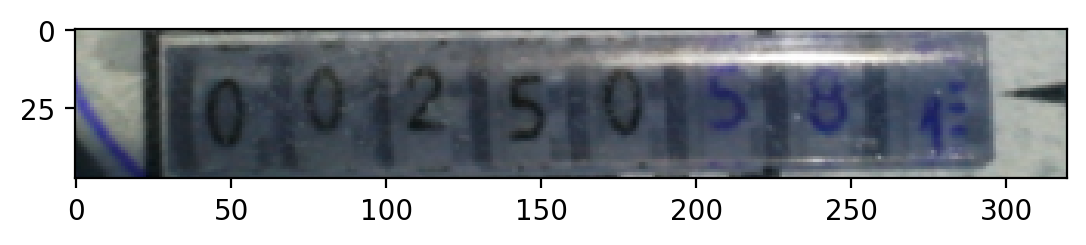

In [ ]:
layer = torch.nn.AdaptiveAvgPool2d((48, 320))
t = torch.tensor(cropped_1.transpose((2, 0, 1))/255)
plt.imshow(np.array(layer(t)).transpose((1, 2, 0)))
plt.show()

In [ ]:
cropped_3 = rotate_image_obb(pred_3[0])

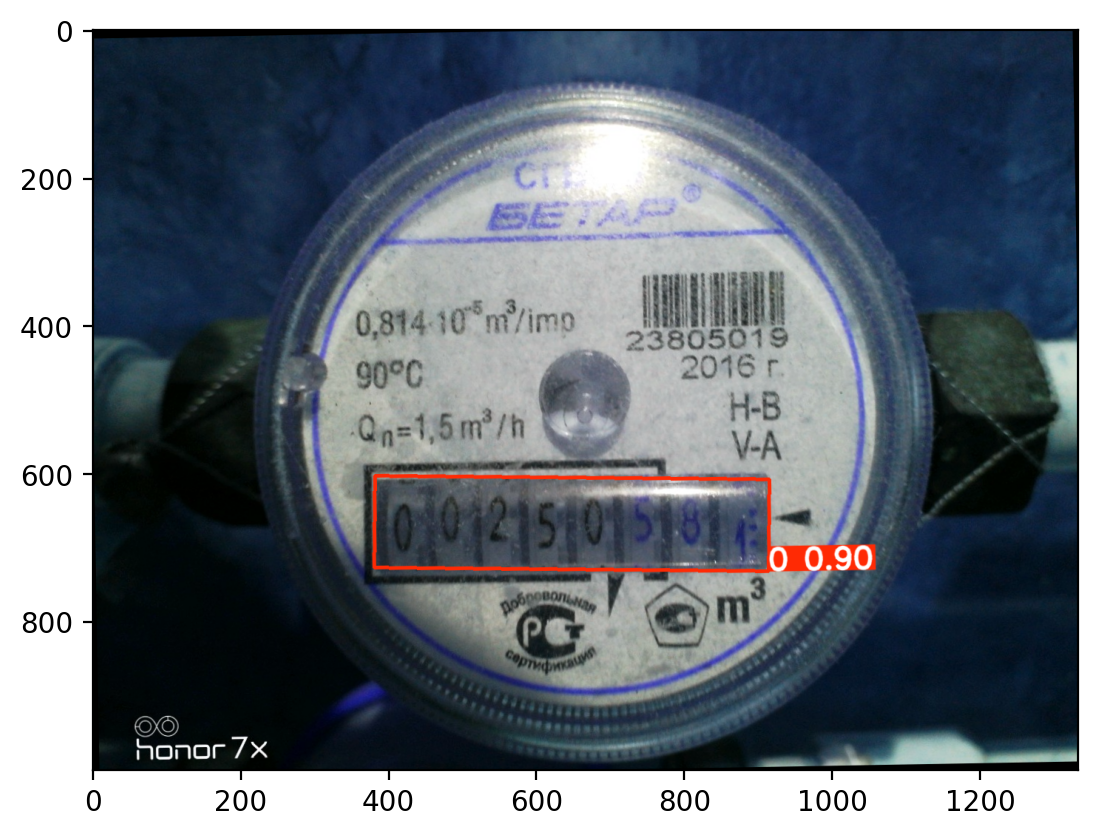

In [ ]:
plt.imshow(np.array(cropped_3))
plt.show()

# 4. PaddleOCR для чтения с изображения

## 4.1. Подготовка датасета

Подготовка датасета будет состоять только в том чтобы заменить имеющиеся файлы в папках с изображениями на их обрезанные версии.

Датасет для paddleOCR выглядит иначе, для него данные и директории были подготовлены отдельно, именно там файлы с фотографиями и будут корректироваться под поворот и кроп

Данная часть в работе, поскольку необходимо подготовить данные